In [2]:
import pandas as pd
import numpy as np
import csv
import ast
import matplotlib.pyplot as plt
import bct

In [3]:
def get_coauthor_matrix(df, name_str, coauthor_str):
    ''' 
    PARAMS:
    df: dataframe with at minimum columns containing author names and coauthor dictionary
    name_str: string of author column name in df
    coauthor_str: string of coauthor column name in df

    RETURN:
    coauthor_matrix: numpy array NxN with number of shared co-authored publications
    '''
    names = df.loc[:,name_str]
    coauthor_matrix = np.zeros((names.size, names.size))

    for idx, author in df.iterrows():
        auth_name = author[name_str]
        # row = names[names == auth_name].index[0]
        row = idx
        try:
            coauthors = ast.literal_eval(author[coauthor_str]) #get coauthors
            if len(coauthors) == 0: print(auth_name, "has no coauthors")
            for coauthor in coauthors.keys():
                num_publications = coauthors[coauthor] #number of publications together
                col = names[names == coauthor].index[0]
                coauthor_matrix[col][row] += num_publications

        except:
            print(auth_name, "has no coauthors")
    
    print("\n")
    return coauthor_matrix

In [4]:
combined_df = pd.read_csv("authors_comparisons_updated2.csv")

# get names for axes
sv_names = combined_df["sv_name"].tolist()
gs_names = combined_df["gs_name"].tolist()

# get degrees for comparison
sv_deg = combined_df["sv_degree"].to_list()
gs_deg = combined_df["gs_degree"].to_list()

In [5]:
#create matrix
sv_coauthor_matrix = get_coauthor_matrix(combined_df, "sv_name", "sv_coauthors")
gs_coauthor_matrix = get_coauthor_matrix(combined_df, "gs_name", "gs_coauthors")

Annie Vogel Ciernia has no coauthors
Mark S. Cembrowski has no coauthors
Michael D. Gordon has no coauthors
Manu S. Madhav has no coauthors
Brian Fisher has no coauthors
Emily Lauren Sylwestrak has no coauthors
Anthony Randal McIntosh has no coauthors


Michael Gordon has no coauthors
Manu S Madhav has no coauthors
Emily Sylwestrak has no coauthors




In [6]:
# adjust weights for matrix edges: the higher the publication count, the shorter the distance between nodes

sv_coauthor_matrix[sv_coauthor_matrix > 0] = 1/sv_coauthor_matrix[sv_coauthor_matrix > 0]

gs_coauthor_matrix[gs_coauthor_matrix > 0] = 1/gs_coauthor_matrix[gs_coauthor_matrix > 0]

# find weighted betweenness centrality
gs_weighted_BC = bct.betweenness_wei(sv_coauthor_matrix)
sv_weighted_BC = bct.betweenness_wei(gs_coauthor_matrix)

# normalize for undirected graph
gs_weighted_BC_normed = gs_weighted_BC*2/((len(gs_weighted_BC)-1)*(len(gs_weighted_BC)-2))
sv_weighted_BC_normed = sv_weighted_BC*2/((len(sv_weighted_BC)-1)*(len(sv_weighted_BC)-2))

In [7]:
print(gs_weighted_BC_normed)

[0.67070707 0.         0.1010101  0.12929293 0.06262626 0.07878788
 0.         0.19191919 0.16565657 0.         0.         0.19393939
 0.27878788 0.         0.26666667 0.         0.         0.09090909
 0.22222222 0.0040404  0.         0.         0.         0.
 0.         0.         0.18585859 0.         0.         0.0040404
 0.04242424 0.20808081 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.20808081
 0.         0.         0.         0.07070707]


# Google Scholar only degree and betweenness centrality

In [8]:
#single source plot
gs_df = pd.DataFrame({
    'Author': gs_names,
    'Degree': gs_deg,
    'Betweenness Centrality': gs_weighted_BC_normed,
})

In [9]:
#order the dataframe in descending BC order
ordered_gs_df = gs_df.sort_values(
    by="Betweenness Centrality", 
    ascending=False, 
    ignore_index=True
    )

In [10]:
font_color = '#525252'
deg_color = '#fd625e'
BC_color = '#01b8aa'
index = ordered_gs_df.index
authors = ordered_gs_df['Author']
deg_col = ordered_gs_df['Degree']
BC_col = ordered_gs_df['Betweenness Centrality']
title_deg = 'Degree\nNumber of Direct Co-Authors'
title_BC = 'Betweenness Centrality\nFraction of Shortest Paths'

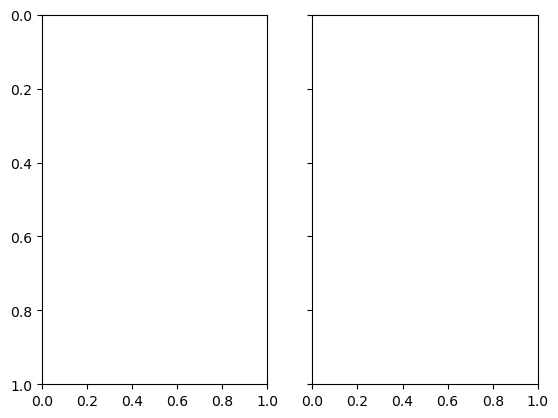

In [11]:
fig, axes = plt.subplots(
    ncols=2, 
    sharey=True #data shares the same y-axis
    )
axes[0].invert_yaxis()

<BarContainer object of 46 artists>

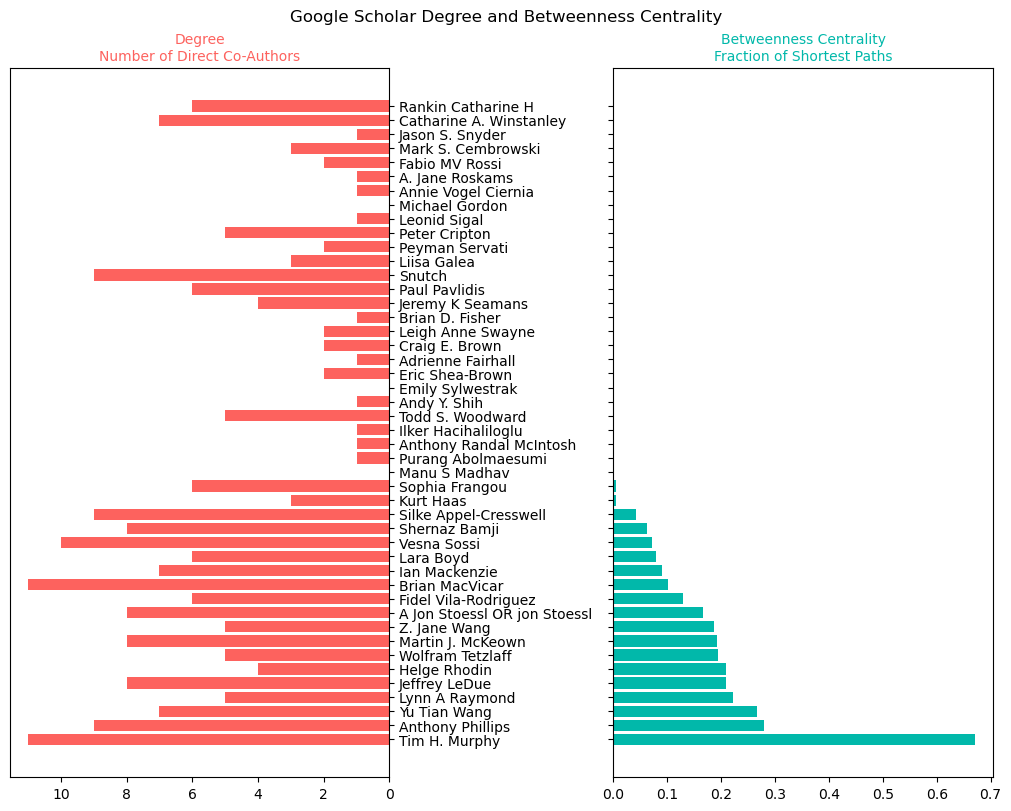

In [12]:
fig, axes = plt.subplots(
    layout='constrained',
    figsize=(10,8), #1000x800px figure
    ncols=2, 
    sharey=True #data shares the same y-axis
    )

axes[0].invert_xaxis()

#set titles
fig.suptitle("Google Scholar Degree and Betweenness Centrality")
axes[0].set_title(title_deg, fontsize=10, color=deg_color)
axes[1].set_title(title_BC, fontsize=10, color=BC_color)

#plot degree axis
axes[0].barh(authors, deg_col, align='center', color=deg_color)
axes[0].yaxis.tick_right()

#plot betweenness centrality axis
axes[1].barh(authors, BC_col, align='center', color=BC_color)

# Google Scholar and SciVal degree and betweenness centrality comparison

In [14]:
#get necessary data for multiple sources
combined_df = pd.DataFrame({
    "Author": gs_names,
    "SciVal Degrees": sv_deg,
    "Google Scholar Degrees": gs_deg,
    "SciVal Betweenness Centrality": sv_weighted_BC_normed,
    "Google Scholar Betweenness Centrality": gs_weighted_BC_normed,
})

#order dataframe
ordered_df = combined_df.sort_values(
    by="Google Scholar Betweenness Centrality", 
    ascending=False, 
    ignore_index=True
    )

In [15]:
degrees = pd.DataFrame({
    "Google Scholar Degrees": ordered_df["Google Scholar Degrees"],
    "SciVal Degrees": ordered_df["SciVal Degrees"],
})

BCs = pd.DataFrame({
    "Google Scholar Betweenness Centrality": ordered_df["Google Scholar Betweenness Centrality"],
    "SciVal Betweenness Centrality": ordered_df["SciVal Betweenness Centrality"],
})

In [16]:
font_color = 'black'
sv_colors = {
    "degree":'mediumturquoise',
    "BC":'gold'
}
gs_colors = {
    "degree":'darkcyan',
    "BC":'darkgoldenrod'
}
# sv_deg_color = 'red'
# sv_BC_color = 'orange'
# gs_deg_color = 'blue'
# gs_BC_color = 'green'
index = ordered_df.index
authors = ordered_df['Author']
# deg_col = ordered_gs_df['Degree']
# BC_col = ordered_gs_df['Betweenness Centrality']
title_deg = 'Degree\nNumber of Direct Co-Authors'
title_BC = 'Betweenness Centrality\nFraction of Shortest Paths'

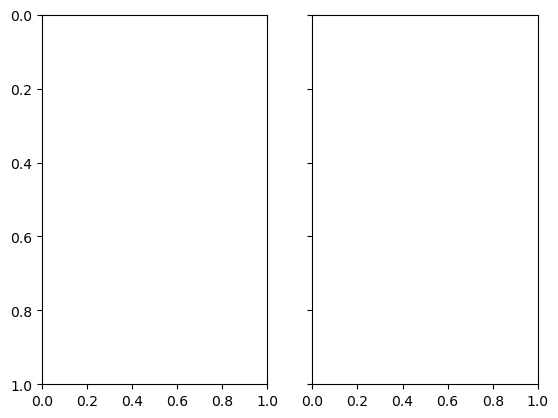

In [17]:
#invert y axis for graph
fig, axes = plt.subplots(
    ncols=2, 
    sharey=True #data shares the same y-axis
    )
axes[0].invert_yaxis()

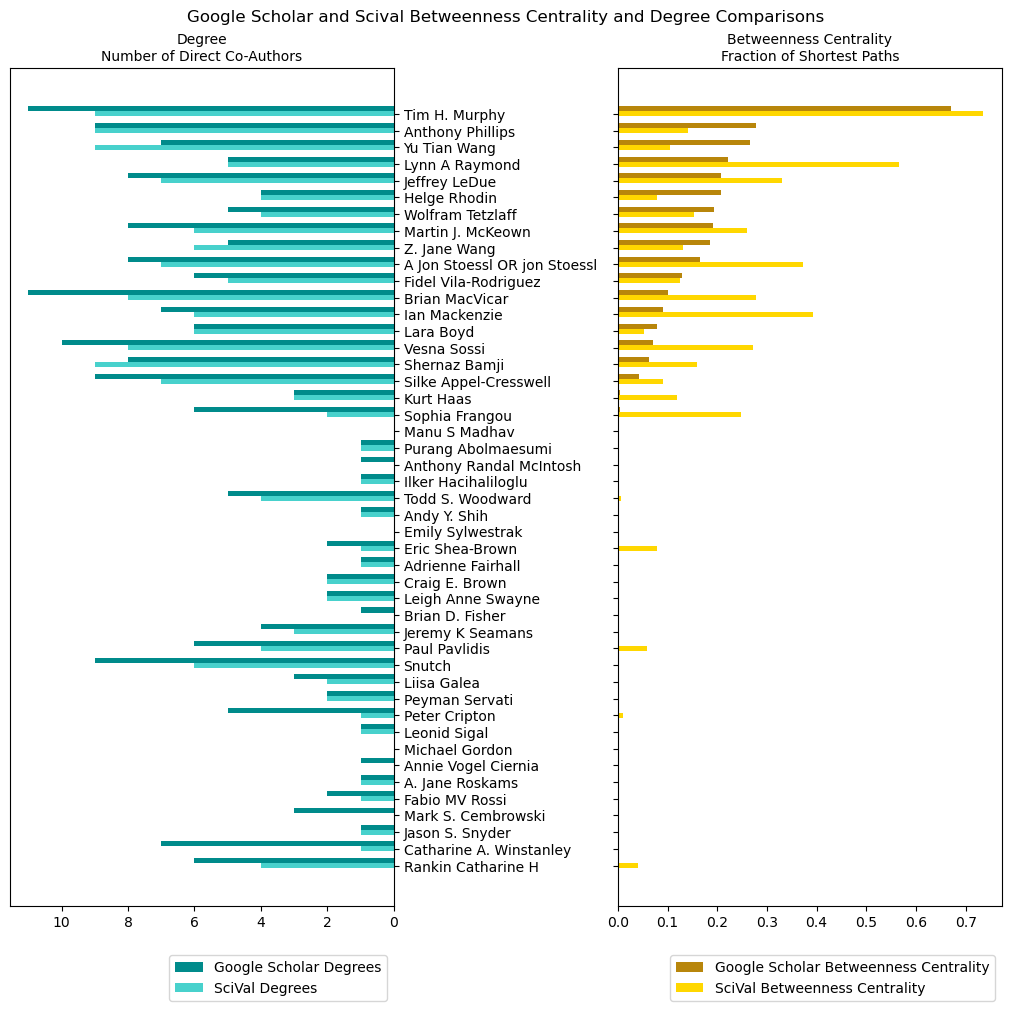

In [18]:
fig, axes = plt.subplots(
    layout='constrained',
    figsize=(10,10), #1000x1000px figure
    ncols=2, 
    sharey=True #data shares the same y-axis
    )

x = np.arange(len(ordered_df["Author"]))
width = 0.3
multiplier = 0

#modify axes
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].yaxis.tick_right()
axes[0].set_yticks(x + width, labels=ordered_df["Author"].to_list());

#plot degrees
axes[0].set_title(title_deg, fontsize=10)
for source, data in degrees.items():
    if "Google" in source: color = gs_colors["degree"]
    else: color = sv_colors["degree"]
    offset = width * multiplier
    axes[0].barh(x + offset, data, width, label=source, color=color)
    multiplier += 1

#plot BC
multiplier = 0
axes[1].set_title(title_BC, fontsize=10)
for source, data in BCs.items():
    if "Google" in source: color = gs_colors["BC"]
    else: color = sv_colors["BC"]
    offset = width * multiplier
    axes[1].barh(x + offset, data, width, label=source, color=color)
    multiplier += 1

axes[0].legend(bbox_to_anchor=(1, -0.05));
axes[1].legend(bbox_to_anchor=(1, -0.05));

fig.suptitle("Google Scholar and Scival Betweenness Centrality and Degree Comparisons")
plt.show()

In [ ]:
ordered_df.to_csv("GS_SciVal_comparison.csv", index_label=False)

# database comparison graph with a cutoff

In [19]:
cutoff = {}
for key in ordered_df:
    cutoff[key] = ordered_df[key][:15] #15 authors with highest BC value

cutoff_df = pd.DataFrame(cutoff)

degrees = pd.DataFrame({
    "Google Scholar Degrees": cutoff_df["Google Scholar Degrees"],
    "SciVal Degrees": cutoff_df["SciVal Degrees"],
})

BCs = pd.DataFrame({
    "Google Scholar Betweenness Centrality": cutoff_df["Google Scholar Betweenness Centrality"],
    "SciVal Betweenness Centrality": cutoff_df["SciVal Betweenness Centrality"],
})

In [20]:
print(len(cutoff_df["Author"]))

15


In [ ]:
# #invert y axis for graph, if axes[0].invert_yaxis() has never been run before
# #running this code again will invert the already inverted axis 
# fig, axes = plt.subplots(
#     ncols=2, 
#     sharey=True #data shares the same y-axis
#     )
# axes[0].invert_yaxis()

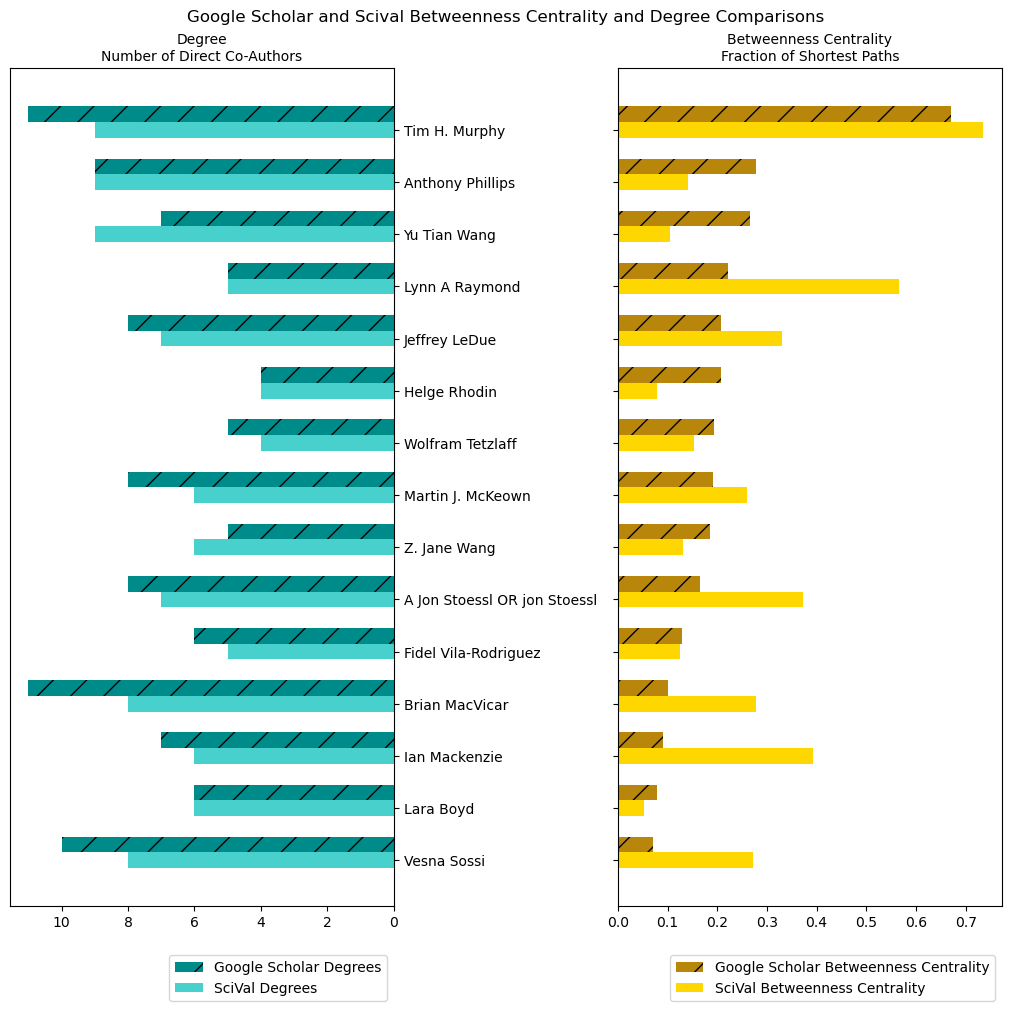

In [25]:
fig, axes = plt.subplots(
    layout='constrained',
    figsize=(10,10), #1000x1000px figure
    ncols=2, 
    sharey=True #data shares the same y-axis
    )

x = np.arange(len(cutoff_df["Author"]))
width = 0.3
multiplier = 0

#modify axes
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].yaxis.tick_right()
axes[0].set_yticks(x + width, labels=cutoff_df["Author"].to_list());

#plot degrees
axes[0].set_title(title_deg, fontsize=10)
for source, data in degrees.items():
    if "Google" in source: 
        color = gs_colors["degree"]
        hatch = "/"
    else: 
        color = sv_colors["degree"]
        hatch = ""
    offset = width * multiplier
    axes[0].barh(x + offset, data, width, label=source, color=color, hatch=hatch)
    multiplier += 1


#plot BC
multiplier = 0
axes[1].set_title(title_BC, fontsize=10)
for source, data in BCs.items():
    if "Google" in source: 
        color = gs_colors["BC"] 
        hatch = "/"
    else: 
        color = sv_colors["BC"]
        hatch = ""
    offset = width * multiplier
    axes[1].barh(x + offset, data, width, label=source, color=color, hatch = hatch)
    multiplier += 1

axes[0].legend(bbox_to_anchor=(1, -0.05));
axes[1].legend(bbox_to_anchor=(1, -0.05));

fig.suptitle("Google Scholar and Scival Betweenness Centrality and Degree Comparisons")
plt.show()